##Base import

In [0]:
import sys
import os
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/PRIM'  # your new root path

sys.path.append(os.path.join(root_path, 'notebooks')) # for importing from utils.py

!pip install face_recognition

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import argparse
import pickle
import cv2
from imutils import paths
import face_recognition
import argparse
import pickle
import cv2
import os
import dlib
import matplotlib.pyplot as plt
import time
import pdb
import numpy as np
import random
print(dlib.DLIB_USE_CUDA)

True


##Main code

The code below is the same used in the main notebook to generate the logs and the statistics. It is written taking into account the possibility that more than one person can be on the screen at the same time. It compears all their encodings with the saved ones of the person we want to recognise. As a final resul we can track our subject even if he/she is not the only person in the video.

In [0]:
def faceRecognition(image, encodings, detection='cnn', show=False , tolerance = 0.6):
    start = time.time()
    # the image is already converted in an rgb format
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # format used by openCV
    data = encodings

    # detect the (x, y)-coordinates of the bounding boxes corresponding
    # to each face in the input image, then compute the facial embeddings
    # for each face
    boxes = face_recognition.face_locations(rgb,model=detection)
    encodings = face_recognition.face_encodings(rgb, boxes)

    # initialize the list of names for each face detected
    names = []

    # loop over the facial embeddings--> all the code bwlow is 
    for encoding in encodings:
        # attempt to match each face in the input image to our known
        # encodings
        matches = face_recognition.compare_faces(data["encodings"],encoding, tolerance= tolerance)
        name = "unknown"

        # check to see if we have found a match
        if True in matches:
          # Or instead, use the known face with the smallest distance to the new face
          face_distances = face_recognition.face_distance(data["encodings"], encoding)
          best_match_index = np.argmin(face_distances)
          print(face_distances )
          if matches[best_match_index]:
              name = data["names"][best_match_index]

        # update the list of names
        try:
            name = name.split('/')[2]
        except:
            name = name
        names.append(name)

    # loop over the recognized faces
    image2 = image.copy()
    for ((top, right, bottom, left), name) in zip(boxes, names):
        # draw the predicted face name on the image
        cv2.rectangle(image2, (left, top), (right, bottom), (0, 255, 0), 2)
        y = top - 15 if top - 15 > 15 else top + 15
        cv2.putText(image2, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX,
            0.75, (0, 255, 0), 2)
    
    
    stop = time.time()
    #print('Time needed:', stop-start, 'sec')
    # show the output image
    rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    if(show== True):
        print(names)
        plt.imshow(rgb)
        plt.show()
    return names

def imageRead(path, show=True):
    # BGR FORMAT #
    image = cv2.imread(path)
    
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if(show== True):
        plt.imshow(rgb)
        plt.show()
    return image
    
def encodingsRead(path):
    ## PAY ATTENTION:: You need to create the encoding for you dataset using encode_face.py
    data = pickle.loads(open(path, "rb").read())
    return data

##Experiments

In [0]:
encodings_folder = root_path + "/encodings/"
test_path = root_path + "/frame_images_mattia/"

We take as an example a very bad recognition made by the algorithm.<br>
The two person are:
* Jack_Osbourne (first image) - the one we want to recognize
* Krishna_Bhadur_Mahara (second image) - the test
 
Stats:
* 0.57% (not recognized/detected) 
* 0.43% (recognized)
 
We can notice that even if they are clearly two different person the algorithm recognizes them as the same, maybe due to the fact that they have some common facial traits such as glasses, similar shape of face and nose, etc.


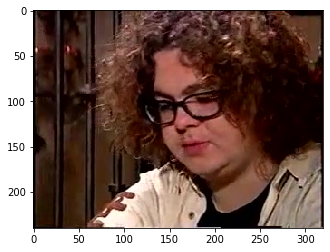

In [0]:
person_path = test_path+"Jack_Osbourne/0/"

imagePathsList = os.listdir(person_path)
imagePaths = random.choice(imagePathsList)
img = imageRead(person_path+imagePaths)

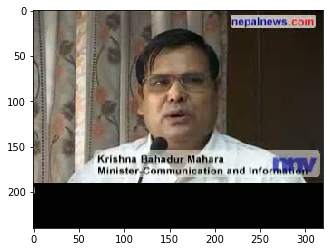

In [0]:
true_person_enc = encodingsRead(encodings_folder+"Jack_Osbourne.pkl") 
person_path = test_path+"Krishna_Bhadur_Mahara/5/"
imagePathsList = os.listdir(person_path)
imagePaths = random.choice(imagePathsList)
img = imageRead(person_path+imagePaths)

[0.6303573  0.66130871 0.62788502 0.61581263 0.64943907 0.61939545
 0.62861829 0.68914578 0.6538624  0.68293591 0.63029639 0.62069626
 0.6538624  0.62564295 0.61221233 0.66194649 0.66130871 0.59526022
 0.63355859 0.6628092 ]
['Jack_Osbourne']


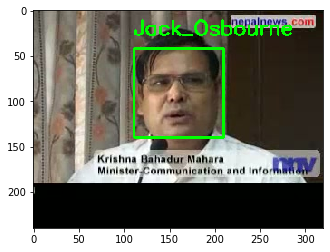

['Jack_Osbourne']

In [0]:
faceRecognition(img,true_person_enc,show = True)

This is how it works:<br>
If at least one match is returned by the function **face_recognition.compare_faces** then the **face_recognition.face_distance** function, given a list of face encodings, compare them with the known face encoding (that have been previously generated and loaded) and get a Euclidean distance for each comparison face. The distance tells how similar the faces are.<br>
In our implementation it returns a NumPy ndarray that represents the distance from the current face encoding to all the ones that have been previously saved and that have a match. The choice is based on the smallest distance in this vector.
 
All the distances are normalized in the range $[0,1]$ and the compare_faces methods is also based on them to see of there is a match or not<br>
This distance can be seen as confidence on the image recognized.


The function **face_recognition.compare_faces** has also a **tolerance** parameter, it says how great the distance between the faces has to be in order to have a match. <br>
Lower tolerance represent a more strict condition. <br>
Based on the documentation ‘0.6’ (default value) is typically the one that gives best performance.
As we can see these value is not always optimal for us so to have a greater reliability of the face matching we have to tune properly this parameter. In the example showed below using "tolerance = 0.1" we correct the error previously made.
The problem is that probably with such strict tolerance the TAR is going to be lower (bad) but at the same time also FAR should decrease.


['unknown']


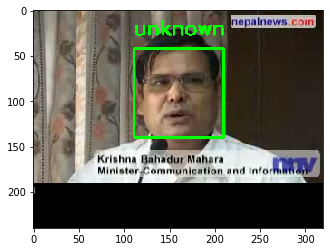

['unknown']

In [0]:
faceRecognition(img,true_person_enc,show = True, tolerance= 0.1)